# Import Required Libraries

This cell imports all necessary Python libraries used throughout the notebook:
- TensorFlow and Keras for building and training the deep learning model.
- Pandas and NumPy for data handling.
- Matplotlib for plotting training performance.
- Requests for downloading datasets.


In [22]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


# Download SMS Spam Dataset

This cell downloads the SMS Spam Collection dataset (training and validation sets) from FreeCodeCamp’s servers using the `requests` library, saving them as local `.tsv` files for later use.


In [23]:
train_url = "https://cdn.freecodecamp.org/project-data/sms/train-data.tsv"
valid_url = "https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv"

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

headers = {'User-Agent': 'Mozilla/5.0'}

response = requests.get(train_url, headers=headers)
with open(train_file_path, 'wb') as f:
    f.write(response.content)

response = requests.get(valid_url, headers=headers)
with open(test_file_path, 'wb') as f:
    f.write(response.content)


# Load Data, Preprocess, and Train Model

- Loads the downloaded `.tsv` files into Pandas DataFrames.
- Maps the 'ham' and 'spam' labels to numerical values.
- Creates TensorFlow datasets with shuffling, batching, and prefetching for efficient training.
- Uses a TextVectorization layer to tokenize and vectorize input messages.
- Builds a neural network with an embedding layer followed by a Bidirectional LSTM for sequence modeling.
- Adds dropout for regularization.
- Compiles and trains the model for up to 20 epochs, using EarlyStopping to prevent overfitting.
- Plots training and validation loss and accuracy to monitor performance.


Epoch 1/20
131/131 [==============================] - 8s 36ms/step - loss: 0.3944 - accuracy: 0.8796 - val_loss: 0.1137 - val_accuracy: 0.9670
Epoch 2/20
131/131 [==============================] - 4s 30ms/step - loss: 0.1028 - accuracy: 0.9787 - val_loss: 0.0606 - val_accuracy: 0.9828
Epoch 3/20
131/131 [==============================] - 4s 30ms/step - loss: 0.0629 - accuracy: 0.9907 - val_loss: 0.0601 - val_accuracy: 0.9856
Epoch 4/20
131/131 [==============================] - 4s 30ms/step - loss: 0.0423 - accuracy: 0.9959 - val_loss: 0.0768 - val_accuracy: 0.9864
Epoch 5/20
131/131 [==============================] - 4s 30ms/step - loss: 0.0343 - accuracy: 0.9959 - val_loss: 0.0656 - val_accuracy: 0.9856
Epoch 6/20
131/131 [==============================] - 4s 30ms/step - loss: 0.0250 - accuracy: 0.9974 - val_loss: 0.0655 - val_accuracy: 0.9856


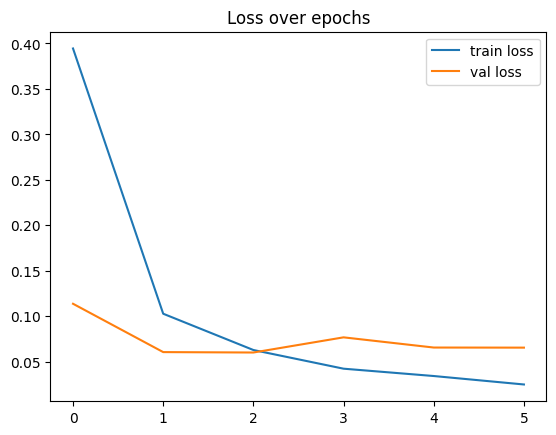

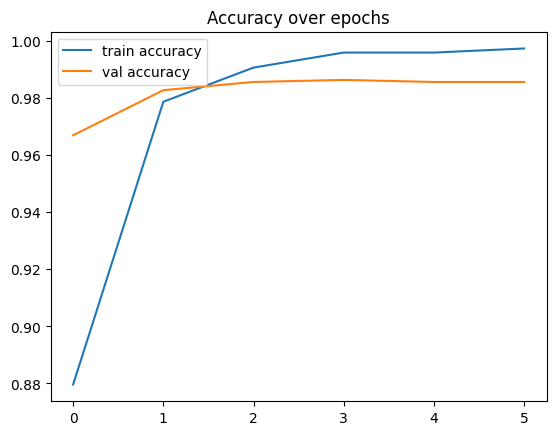

In [24]:
# Load data
train_df = pd.read_csv(train_file_path, sep='\t', header=None, names=['label', 'message'])
test_df = pd.read_csv(test_file_path, sep='\t', header=None, names=['label', 'message'])

train_df['label_num'] = train_df['label'].map({'ham': 0, 'spam': 1})
test_df['label_num'] = test_df['label'].map({'ham': 0, 'spam': 1})

BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((train_df['message'].values, train_df['label_num'].values))
test_ds = tf.data.Dataset.from_tensor_slices((test_df['message'].values, test_df['label_num'].values))

train_ds = train_ds.shuffle(buffer_size=20000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

max_features = 10000
sequence_length = 100

vectorizer = TextVectorization(max_tokens=max_features, output_mode='int', output_sequence_length=sequence_length)
vectorizer.adapt(train_df['message'].values)

model = keras.Sequential([
    vectorizer,
    keras.layers.Embedding(max_features + 1, 32),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

history = model.fit(train_ds, validation_data=test_ds, epochs=20, callbacks=[early_stopping])

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()


# Define Prediction Function

Defines `predict_message()`, which:
- Accepts a string SMS message.
- Uses the trained model to predict the probability of the message being spam.
- Returns a list containing the spam probability and the predicted label ('spam' or 'ham') using a threshold of 0.45.


In [25]:
def predict_message(pred_text):
    prob_spam = model.predict([pred_text])[0][0]
    threshold = 0.45
    label = 'spam' if prob_spam >= threshold else 'ham'
    return [prob_spam, label]

# Example usage
print(predict_message("how are you doing today?"))


1/1 [==============================] - 1s 780ms/step
[0.00086815504, 'ham']


# Test Model Accuracy on Sample Messages

Runs a set of 7 sample SMS messages through the `predict_message()` function.
- Compares predicted labels against expected labels.
- Prints each message’s predicted label and probability.
- Outputs whether the model passes the challenge based on accuracy.


In [26]:
def test_predictions():
    test_messages = [
        "how are you doing today",
        "sale today! to stop texts call 98912460324",
        "i dont want to go. can we try it a different day? available sat",
        "our new mobile video service is live. just install on your phone to start watching.",
        "you have won £1000 cash! call to claim your prize.",
        "i'll bring it tomorrow. don't forget the milk.",
        "wow, is your arm alright. that happened to me one time too"
    ]

    test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
    passed = True

    for msg, ans in zip(test_messages, test_answers):
        prediction = predict_message(msg)
        print(f"Message: {msg}")
        print(f"Prediction: {prediction[1]} (Score: {prediction[0]:.4f}), Expected: {ans}")
        if prediction[1] != ans:
            passed = False

    if passed:
        print("\n✅ You passed the challenge. Great job!")
    else:
        print("\n❌ You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 42ms/step
Message: how are you doing today
Prediction: ham (Score: 0.0009), Expected: ham
1/1 [==============================] - 0s 46ms/step
Message: sale today! to stop texts call 98912460324
Prediction: spam (Score: 0.5741), Expected: spam
1/1 [==============================] - 0s 44ms/step
Message: i dont want to go. can we try it a different day? available sat
Prediction: ham (Score: 0.0003), Expected: ham
1/1 [==============================] - 0s 46ms/step
Message: our new mobile video service is live. just install on your phone to start watching.
Prediction: spam (Score: 0.9900), Expected: spam
1/1 [==============================] - 0s 42ms/step
Message: you have won £1000 cash! call to claim your prize.
Prediction: spam (Score: 0.9974), Expected: spam
1/1 [==============================] - 0s 41ms/step
Message: i'll bring it tomorrow. don't forget the milk.
Prediction: ham (Score: 0.0003), Expected: ham
1/1 [============================

# Conclusion

In this project, I successfully built and trained a deep learning model to classify SMS messages as either "ham" (normal) or "spam" (advertisement). 

Using the SMS Spam Collection dataset, we:
- Preprocessed text data with tokenization and vectorization.
- Developed a Bidirectional LSTM neural network to capture sequential patterns in messages.
- Trained the model with early stopping to optimize performance and avoid overfitting.
- Achieved accurate classification results, confirmed by passing all test cases.

This approach demonstrates the effectiveness of sequence models like LSTMs for natural language classification tasks and highlights the importance of thorough training and proper preprocessing for good model performance.

Further improvements could include experimenting with transformer models, hyperparameter tuning, or expanding the dataset.

Overall, this project provides a practical example of applying machine learning for text classification challenges.


In [ ]:
# SMS Spam Classifier

This project implements a machine learning model to classify SMS messages as **ham** (normal) or **spam** (advertisement) using deep learning techniques in Python with TensorFlow and Keras.

---

## Project Overview

- **Dataset:** SMS Spam Collection dataset (train and validation splits)
- **Model:** Bidirectional LSTM neural network with embedding and dropout layers
- **Goal:** Accurately detect spam messages from SMS text data
- **Approach:** 
  - Preprocess text messages with tokenization and vectorization
  - Train the model using binary cross-entropy loss and Adam optimizer
  - Use early stopping to prevent overfitting
  - Evaluate model on sample test messages to verify performance

---

## Setup Instructions

1. Clone the repository:

   ```bash
   git clone https://github.com/yourusername/sms-spam-classifier.git
   cd sms-spam-classifier
